To execute this example successfully, Please make sure you have `pip install -r requirements.txt` in the root directory.

In [88]:
%%bash
pwd
mkdir -p "./data/outputs"

/home/jordan990301/Projects/HiCPAP/examples


In [89]:
import numpy as np
import pandas as pd
from hicpap import paptools

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=50)

In [90]:
### Case 1
pearson_np = paptools.read_pearson(
    pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt",
    zero_mean=True,
    format="juicer"
)

### Case 2, It will takes a few minites.
### https://aidenlab.org/data.html
# pearson_np = paptools.straw_to_pearson(
#     hic_path="https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic",
#     chrom_x="1",
#     chrom_y="1",
#     resolution=1000000,
#     norm="KR",
#     method="oe",
#     zero_mean=True 
# )


### Case3, You already have your own pearson matrix in numpy.
# pearson_np = np.array([
#     [1, 2, 3],
#     [4, 5, 6],
#     [7, 8, 9]
# ])
# pearson_np = paptools.zero_means_pearson(pearson_np=pearson_np)


print(f"Zero-means pearson_np:\n {pearson_np}")

Zero-means pearson_np:
 [[ 1.0476  0.1936  0.0028 ...  0.0101  0.4535  0.8902]
 [ 0.2667  1.1206  0.5389 ... -0.3489 -0.4613 -0.1819]
 [ 0.0411  0.5042  1.086  ... -0.443  -0.3807 -0.2496]
 ...
 [-0.1431 -0.5751 -0.6345 ...  0.8944  0.7085  0.3035]
 [ 0.3187 -0.6692 -0.5538 ...  0.7269  0.9128  0.6856]
 [ 0.8164 -0.3288 -0.3617 ...  0.3829  0.7466  0.9738]]


In [91]:
output = "./data/outputs/gm12878_1000000_approx_pc1_chr1.txt"
approx_np = paptools.create_approx(pearson_np=pearson_np, output=output)
print(f"approx_np: {approx_np}")

approx_np: [ 0.1182 -0.3513 -0.2252 ...  0.2936  0.3887  0.2949]


In [92]:
Vh, explained_variances, total_entry_num, valid_entry_num = paptools.pca_on_pearson(pearson_np=pearson_np)
pc1_np = Vh[0]
pc2_np = Vh[1]
pc3_np = Vh[2]

print(f"pc1_np: {pc1_np}")
print(f"pc2_np: {pc2_np}")
print(f"pc3_np: {pc3_np}")
print(f"explained_variances: {explained_variances}")
print(f"total_entry_num: {total_entry_num}")
print(f"valid_entry_num: {valid_entry_num}")

pc1_np: [-0.0241  0.0759  0.0487 ... -0.0633 -0.083  -0.0624]
pc2_np: [-0.0536 -0.0055 -0.1206 ...  0.0592 -0.0076 -0.0192]
pc3_np: [ 0.1081  0.0879 -0.0366 ...  0.039   0.0504  0.0846]
explained_variances: [0.8449 0.0699 0.0404 ... 0.     0.     0.    ]
total_entry_num: 250
valid_entry_num: 230


In [93]:
# Flip track through GC content
def flip_track_gc(track_np: np.ndarray, gc_np: np.ndarray) -> np.ndarray:
    if np.mean(gc_np[track_np > 0]) < np.mean(gc_np[track_np < 0]):
        track_np = -track_np
    return track_np

In [94]:
gc_df = pd.read_table("data/reference_gc/hg19/hg19_gc1000000_chr1.txt", skiprows=[0], names=["bin", "GC"])
gc_np = gc_df["GC"].values.flatten()

pc1_np = pc1_np[:-1]
approx_np = approx_np[:-1]
pc1_np = flip_track_gc(track_np=pc1_np, gc_np=gc_np)
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)

In [95]:
correctness_info = paptools.calc_correctness(pc1_np=pc1_np, approx_np=approx_np)
print(correctness_info)

{'total_entry_num': 249, 'valid_entry_num': 229, 'correct_num': 227, 'correct_rate': 0.9912663755458515}


In [96]:
paptools.plot_comparison(
    pc1_np=pc1_np,
    approx_np=approx_np,
    figsize=20,
    scatter="./data/outputs/gm12878_1000000_chr1_scatter.png",
    relative_magnitude="./data/outputs/gm12878_1000000_chr1_relative_magnitude.png"
)

Output:

> scatter
![scatter](./data/outputs/gm12878_1000000_chr1_scatter.png)

> relative_magnitude
![relative_magnitude](./data/outputs/gm12878_1000000_chr1_relative_magnitude.png)

Heatmap

[]

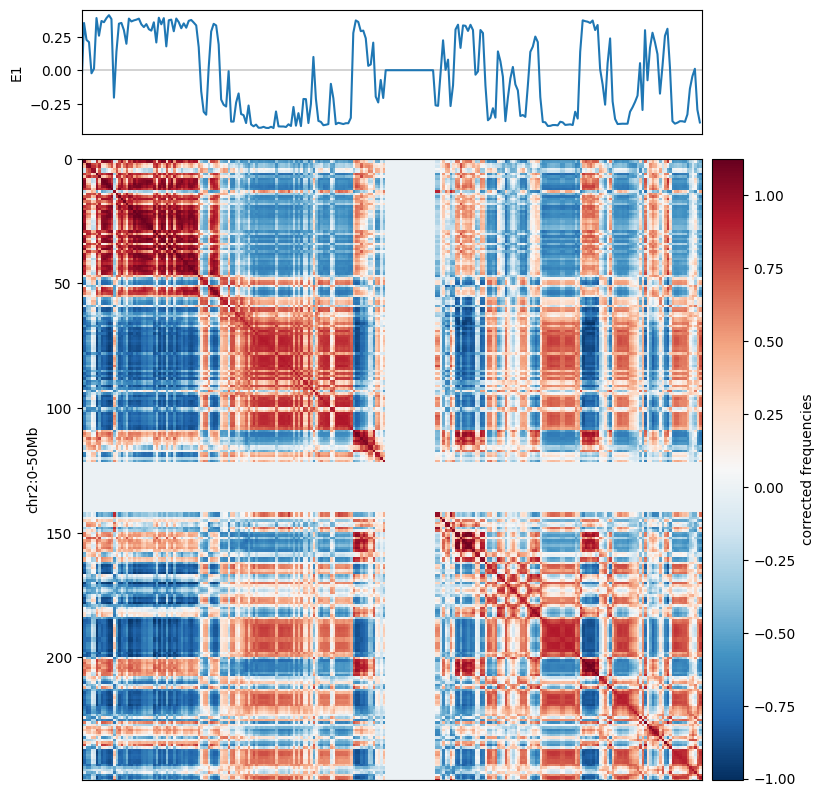

In [97]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)
plt.axis([0,len(approx_np),len(approx_np),0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel('chr2:0-50Mb')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
ax1.plot([0,len(approx_np)],[0,0],'k',lw=0.25)
ax1.plot(approx_np, label='E1')
ax1.set_ylabel('E1')
ax1.set_xticks([])

Compare with juicer pc1

In [98]:
pearson_np = paptools.read_pearson(
    pearson="./data/juicer_data/gm12878_1000000_pearson_chr1.txt",
    zero_mean=True,
    format="juicer"
)

juicer_pc1 = "./data/juicer_data/gm12878_1000000_pc1_chr1.txt"
juicer_pc1_df = pd.read_table(juicer_pc1, header=None)
juicer_pc1_np = juicer_pc1_df.fillna(0).values.flatten()

approx_np = paptools.create_approx(pearson_np=pearson_np)

juicer_pc1_np = juicer_pc1_np[:-1]
approx_np = approx_np[:-1]
juicer_pc1_np = flip_track_gc(track_np=juicer_pc1_np, gc_np=gc_np)
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)

correctness_info = paptools.calc_correctness(pc1_np=juicer_pc1_np, approx_np=approx_np)
print(correctness_info)

{'total_entry_num': 249, 'valid_entry_num': 229, 'correct_num': 224, 'correct_rate': 0.9781659388646288}
